In [5]:
# Hobo Temperature Sensor Analysis - Raw Cooler System
# Analysis of temperature data from a cooler with setpoint of 32°F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Hobo Temperature Sensor Data Analysis - Raw Cooler")
print("==================================================")
print("System: Raw Cooler/Refrigeration")
print("Setpoint: 32°F (0°C)")
print("Analysis Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print()


Hobo Temperature Sensor Data Analysis - Raw Cooler
System: Raw Cooler/Refrigeration
Setpoint: 32°F (0°C)
Analysis Date: 2025-08-24 20:39:03



Dairy cooler (refrigerated)
For storing perishable dairy items like milk, cream, and yogurt, the temperature should be set to:
34–38°F (1–3°C).

In [7]:
## 1. DATA LOADING AND CLEANING

def load_hobo_cooler_data(filename):
    """Load hobo temperature data from Excel file for cooler system"""
    try:
        # Load the main data sheet
        df = pd.read_excel(filename, sheet_name='Data')
        
        # Load events and details if available
        events_df = None
        details_df = None
        
        try:
            events_df = pd.read_excel(filename, sheet_name='Events')
            print("Events sheet loaded successfully")
        except:
            print("No events sheet found or unable to load")
            
        try:
            details_df = pd.read_excel(filename, sheet_name='Details')
            print("Details sheet loaded successfully")
        except:
            print("No details sheet found or unable to load")
        
        return df, events_df, details_df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

def clean_cooler_temperature_data(df):
    """Clean and prepare cooler temperature data for analysis"""
    # Make a copy
    df_clean = df.copy()
    
    # Rename columns for easier handling
    df_clean.columns = ['Index', 'DateTime', 'Temperature_C']
    
    # Convert datetime
    df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'])
    
    # Convert temperature to numeric and remove any invalid values
    df_clean['Temperature_C'] = pd.to_numeric(df_clean['Temperature_C'], errors='coerce')
    
    # Convert to Fahrenheit
    df_clean['Temperature_F'] = df_clean['Temperature_C'] * 9/5 + 32
    
    # Remove any rows with missing data
    df_clean = df_clean.dropna()
    
    # Sort by datetime
    df_clean = df_clean.sort_values('DateTime').reset_index(drop=True)
    
    # Calculate time differences for sampling rate analysis
    df_clean['TimeDiff'] = df_clean['DateTime'].diff().dt.total_seconds()
    
    print(f"Data cleaned: {len(df_clean)} valid data points")
    print(f"Date range: {df_clean['DateTime'].min()} to {df_clean['DateTime'].max()}")
    print(f"Temperature range: {df_clean['Temperature_F'].min():.1f}°F to {df_clean['Temperature_F'].max():.1f}°F")
    print(f"Average sampling interval: {df_clean['TimeDiff'].median():.0f} seconds")
    
    return df_clean

# Load the data
print("Loading cooler data...")
df_raw, events_df, details_df = load_hobo_cooler_data('../data/hobo/22278546 2025-08-15 11_34_16 PDT FinishedGoodCooler.xlsx')

if df_raw is not None:
    print(f"Raw data shape: {df_raw.shape}")
    print(f"Raw data columns: {df_raw.columns.tolist()}")
    
    # Clean the data
    df = clean_cooler_temperature_data(df_raw)
    
    print(f"\nCleaned data shape: {df.shape}")
else:
    print("Failed to load data")

Loading cooler data...
Events sheet loaded successfully
Details sheet loaded successfully
Raw data shape: (80627, 3)
Raw data columns: ['#', 'Date-Time (PDT)', 'Temperature , °C']
Data cleaned: 80627 valid data points
Date range: 2025-06-20 11:47:06 to 2025-08-15 11:33:06
Temperature range: 31.5°F to 74.8°F
Average sampling interval: 60 seconds

Cleaned data shape: (80627, 5)


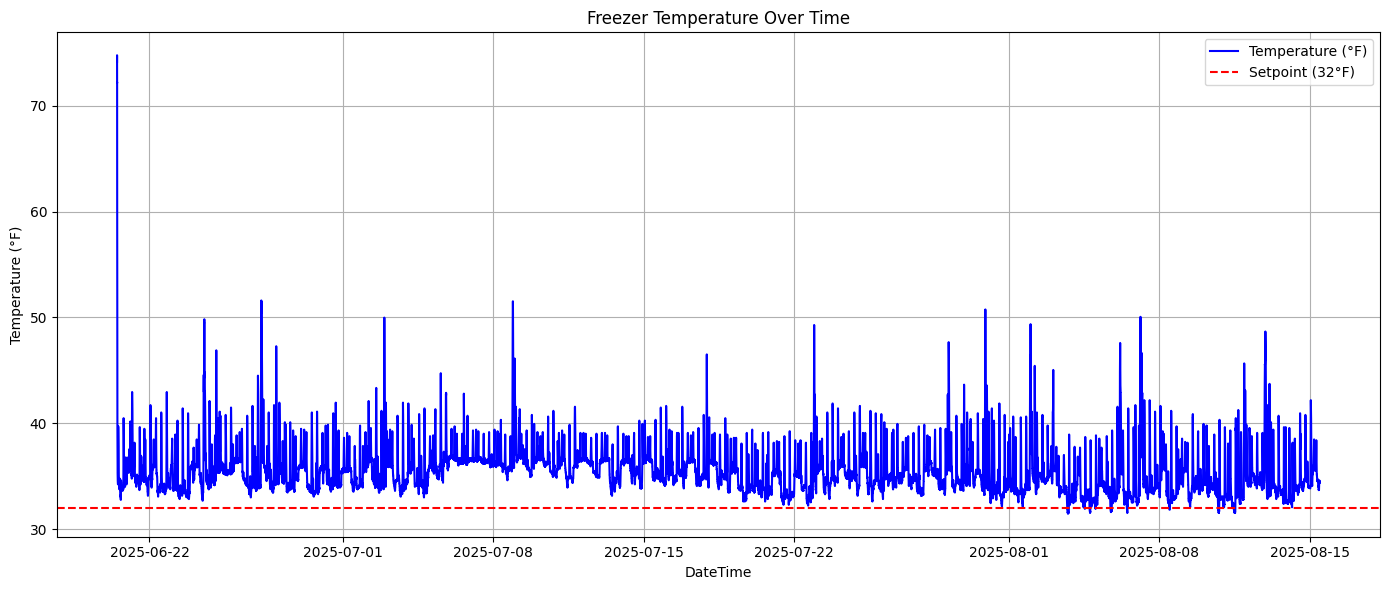

In [8]:
# Make a plot of the raw temperature data for exploratory analysis
plt.figure(figsize=(14, 6))
plt.plot(df['DateTime'], df['Temperature_F'], label='Temperature (°F)', color='blue')
plt.axhline(32, color='red', linestyle='--', label='Setpoint (32°F)')
plt.title('Freezer Temperature Over Time')
plt.xlabel('DateTime')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [9]:
## 2. COOLER-SPECIFIC TEMPERATURE METRICS ANALYSIS

def calculate_cooler_metrics(df, setpoint_f=32):
    """Calculate comprehensive temperature metrics for cooler system at 32°F"""
    
    metrics = {}
    
    # Basic statistics
    metrics['setpoint_f'] = setpoint_f
    metrics['setpoint_c'] = (setpoint_f - 32) * 5/9
    metrics['mean_temp_f'] = df['Temperature_F'].mean()
    metrics['mean_temp_c'] = df['Temperature_C'].mean()
    metrics['std_temp_f'] = df['Temperature_F'].std()
    metrics['min_temp_f'] = df['Temperature_F'].min()
    metrics['max_temp_f'] = df['Temperature_F'].max()
    metrics['range_temp_f'] = metrics['max_temp_f'] - metrics['min_temp_f']
    
    # Deviation from setpoint
    df['deviation_f'] = df['Temperature_F'] - setpoint_f
    metrics['mean_deviation_f'] = df['deviation_f'].mean()
    metrics['abs_mean_deviation_f'] = df['deviation_f'].abs().mean()
    metrics['std_deviation_f'] = df['deviation_f'].std()
    
    # Cooler-specific performance metrics (tighter tolerances than freezer)
    tolerance = 3  # ±3°F tolerance for cooler (tighter than freezer)
    df['within_tolerance'] = abs(df['deviation_f']) <= tolerance
    metrics['percent_within_tolerance'] = (df['within_tolerance'].sum() / len(df)) * 100
    
    # Food safety critical temperatures for cooler
    df['above_40f'] = df['Temperature_F'] > 40  # FDA food safety limit
    df['below_freezing'] = df['Temperature_F'] < 32  # Below freezing point
    metrics['percent_above_40f'] = (df['above_40f'].sum() / len(df)) * 100
    metrics['percent_below_freezing'] = (df['below_freezing'].sum() / len(df)) * 100
    
    # Time above/below setpoint
    df['above_setpoint'] = df['Temperature_F'] > setpoint_f
    df['below_setpoint'] = df['Temperature_F'] < setpoint_f
    metrics['percent_above_setpoint'] = (df['above_setpoint'].sum() / len(df)) * 100
    metrics['percent_below_setpoint'] = (df['below_setpoint'].sum() / len(df)) * 100
    
    # Temperature excursions (significant deviations for cooler)
    excursion_threshold = 8  # °F (less than freezer due to tighter requirements)
    df['excursion'] = abs(df['deviation_f']) > excursion_threshold
    metrics['num_excursions'] = df['excursion'].sum()
    metrics['percent_excursions'] = (metrics['num_excursions'] / len(df)) * 100
    
    # Critical temperature zones for food safety
    df['danger_zone'] = (df['Temperature_F'] > 40) & (df['Temperature_F'] < 140)  # FDA danger zone
    metrics['time_in_danger_zone'] = (df['danger_zone'].sum() / len(df)) * 100
    
    # Stability metrics (rate of change)
    df['temp_rate'] = df['Temperature_F'].diff() / (df['TimeDiff'] / 60)  # °F per minute
    metrics['max_heating_rate'] = df['temp_rate'].max()
    metrics['max_cooling_rate'] = df['temp_rate'].min()
    metrics['avg_abs_rate'] = df['temp_rate'].abs().mean()
    
    # Cycling analysis (important for coolers)
    # Detect temperature cycles
    df['temp_smooth'] = df['Temperature_F'].rolling(window=5, center=True).mean()
    df['temp_trend'] = df['temp_smooth'].diff()
    
    # Count cycles (zero crossings in trend)
    trend_signs = np.sign(df['temp_trend'].fillna(0))
    cycle_changes = (trend_signs.diff() != 0).sum()
    metrics['estimated_cycles'] = cycle_changes // 2  # Approximate number of complete cycles
    
    # Time-based analysis
    metrics['total_hours'] = (df['DateTime'].max() - df['DateTime'].min()).total_seconds() / 3600
    metrics['data_points'] = len(df)
    metrics['cycles_per_hour'] = metrics['estimated_cycles'] / metrics['total_hours'] if metrics['total_hours'] > 0 else 0
    
    return metrics, df

# Calculate cooler-specific metrics
print("\n" + "="*60)
print("COOLER TEMPERATURE PERFORMANCE METRICS")
print("="*60)

metrics, df = calculate_cooler_metrics(df, setpoint_f=32)

print(f"Cooler Setpoint: {metrics['setpoint_f']:.1f}°F ({metrics['setpoint_c']:.1f}°C)")
print(f"Monitoring Period: {metrics['total_hours']:.1f} hours ({metrics['total_hours']/24:.1f} days)")
print(f"Total Data Points: {metrics['data_points']:,}")
print()
print("TEMPERATURE STATISTICS:")
print(f"  Mean Temperature: {metrics['mean_temp_f']:.1f}°F ({metrics['mean_temp_c']:.1f}°C)")
print(f"  Temperature Range: {metrics['min_temp_f']:.1f}°F to {metrics['max_temp_f']:.1f}°F")
print(f"  Standard Deviation: {metrics['std_temp_f']:.2f}°F")
print()
print("SETPOINT PERFORMANCE:")
print(f"  Mean Deviation from Setpoint: {metrics['mean_deviation_f']:.2f}°F")
print(f"  Absolute Mean Deviation: {metrics['abs_mean_deviation_f']:.2f}°F")
print(f"  Time Within ±3°F Tolerance: {metrics['percent_within_tolerance']:.1f}%")
print(f"  Time Above Setpoint: {metrics['percent_above_setpoint']:.1f}%")
print(f"  Time Below Setpoint: {metrics['percent_below_setpoint']:.1f}%")
print()
print("FOOD SAFETY METRICS:")
print(f"  Time Above 40°F (FDA Limit): {metrics['percent_above_40f']:.2f}%")
print(f"  Time Below Freezing (32°F): {metrics['percent_below_freezing']:.2f}%")
print(f"  Time in Danger Zone (40-140°F): {metrics['time_in_danger_zone']:.2f}%")
print()
print("SYSTEM PERFORMANCE:")
print(f"  Temperature Excursions (>±8°F): {metrics['num_excursions']:,} ({metrics['percent_excursions']:.2f}%)")
print(f"  Estimated Compressor Cycles: {metrics['estimated_cycles']:,}")
print(f"  Cycling Rate: {metrics['cycles_per_hour']:.1f} cycles/hour")
print(f"  Maximum Heating Rate: {metrics['max_heating_rate']:.2f}°F/min")
print(f"  Maximum Cooling Rate: {metrics['max_cooling_rate']:.2f}°F/min")
print(f"  Average Rate of Change: {metrics['avg_abs_rate']:.3f}°F/min")



COOLER TEMPERATURE PERFORMANCE METRICS
Cooler Setpoint: 32.0°F (0.0°C)
Monitoring Period: 1343.8 hours (56.0 days)
Total Data Points: 80,627

TEMPERATURE STATISTICS:
  Mean Temperature: 35.5°F (2.0°C)
  Temperature Range: 31.5°F to 74.8°F
  Standard Deviation: 2.25°F

SETPOINT PERFORMANCE:
  Mean Deviation from Setpoint: 3.51°F
  Absolute Mean Deviation: 3.51°F
  Time Within ±3°F Tolerance: 46.7%
  Time Above Setpoint: 99.3%
  Time Below Setpoint: 0.7%

FOOD SAFETY METRICS:
  Time Above 40°F (FDA Limit): 4.37%
  Time Below Freezing (32°F): 0.68%
  Time in Danger Zone (40-140°F): 4.37%

SYSTEM PERFORMANCE:
  Temperature Excursions (>±8°F): 3,520 (4.37%)
  Estimated Compressor Cycles: 7,057
  Cycling Rate: 5.3 cycles/hour
  Maximum Heating Rate: 1.54°F/min
  Maximum Cooling Rate: -3.24°F/min
  Average Rate of Change: 0.065°F/min


In [10]:
## 3. COOLER-SPECIFIC VISUALIZATION FUNCTIONS

def plot_cooler_temperature_profile(df, start_date=None, end_date=None, setpoint=32):
    """Plot temperature profile for cooler with food safety zones"""
    
    # Filter data by date range if specified
    if start_date or end_date:
        df_plot = df.copy()
        if start_date:
            df_plot = df_plot[df_plot['DateTime'] >= start_date]
        if end_date:
            df_plot = df_plot[df_plot['DateTime'] <= end_date]
        title_suffix = f" ({start_date} to {end_date})" if start_date and end_date else ""
    else:
        df_plot = df
        title_suffix = ""
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    # Main temperature plot with food safety zones
    ax1.plot(df_plot['DateTime'], df_plot['Temperature_F'], 'b-', linewidth=0.8, alpha=0.7)
    ax1.axhline(y=setpoint, color='green', linestyle='-', linewidth=2, label=f'Setpoint ({setpoint}°F)')
    ax1.axhline(y=40, color='red', linestyle='--', linewidth=2, label='FDA Safety Limit (40°F)')
    ax1.axhline(y=setpoint+3, color='orange', linestyle=':', alpha=0.7, label='±3°F Tolerance')
    ax1.axhline(y=setpoint-3, color='orange', linestyle=':', alpha=0.7)
    
    # Food safety zones
    ax1.fill_between(df_plot['DateTime'], 40, 50, alpha=0.2, color='red', label='Danger Zone (>40°F)')
    ax1.fill_between(df_plot['DateTime'], setpoint-3, setpoint+3, alpha=0.2, color='lightgreen', label='Target Zone')
    ax1.fill_between(df_plot['DateTime'], 20, setpoint, alpha=0.1, color='lightblue', label='Safe Cold Zone')
    
    ax1.set_ylabel('Temperature (°F)', fontsize=12)
    ax1.set_title(f'Cooler Temperature Profile with Food Safety Zones{title_suffix}', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_ylim(df_plot['Temperature_F'].min() - 5, max(45, df_plot['Temperature_F'].max() + 5))
    
    # Deviation plot
    deviation = df_plot['Temperature_F'] - setpoint
    colors = ['red' if x > 0 else 'blue' for x in deviation]
    ax2.scatter(df_plot['DateTime'], deviation, c=colors, alpha=0.6, s=1)
    ax2.axhline(y=0, color='green', linestyle='-', linewidth=1, label='Setpoint')
    ax2.axhline(y=3, color='orange', linestyle=':', alpha=0.7, label='±3°F Tolerance')
    ax2.axhline(y=-3, color='orange', linestyle=':', alpha=0.7)
    ax2.axhline(y=8, color='red', linestyle='--', alpha=0.7, label='Critical Deviation (±8°F)')
    ax2.axhline(y=-8, color='red', linestyle='--', alpha=0.7)
    ax2.fill_between(df_plot['DateTime'], -3, 3, alpha=0.2, color='lightgreen')
    
    ax2.set_ylabel('Deviation from Setpoint (°F)', fontsize=12)
    ax2.set_title('Temperature Deviation Analysis', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Rate of change plot (important for cooler cycling)
    df_plot['temp_rate'] = df_plot['Temperature_F'].diff() / (df_plot['TimeDiff'] / 60)
    ax3.plot(df_plot['DateTime'], df_plot['temp_rate'], 'purple', alpha=0.7, linewidth=0.5)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=1, label='No Change')
    ax3.fill_between(df_plot['DateTime'], -0.5, 0.5, alpha=0.2, color='lightgray', label='Normal Rate')
    
    ax3.set_xlabel('Date/Time', fontsize=12)
    ax3.set_ylabel('Rate of Change (°F/min)', fontsize=12)
    ax3.set_title('Temperature Rate of Change (Cycling Analysis)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout()
    return fig

def plot_cooler_distribution_analysis(df, setpoint=32):
    """Plot cooler-specific temperature distribution and food safety analysis"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Temperature histogram with food safety zones
    bins = np.linspace(df['Temperature_F'].min(), df['Temperature_F'].max(), 50)
    ax1.hist(df['Temperature_F'], bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=setpoint, color='green', linestyle='-', linewidth=3, label=f'Setpoint ({setpoint}°F)')
    ax1.axvline(x=40, color='red', linestyle='--', linewidth=2, label='FDA Limit (40°F)')
    ax1.axvline(x=df['Temperature_F'].mean(), color='blue', linestyle='-', linewidth=2, label=f'Mean ({df["Temperature_F"].mean():.1f}°F)')
    
    # Color zones
    y_max = ax1.get_ylim()[1]
    if setpoint > 20:
        ax1.axvspan(20, setpoint, alpha=0.1, color='lightblue', label='Safe Zone')
    ax1.axvspan(setpoint, 40, alpha=0.1, color='lightgreen', label='Normal Zone')
    if df['Temperature_F'].max() > 40:
        ax1.axvspan(40, df['Temperature_F'].max(), alpha=0.2, color='red', label='Danger Zone')
    
    ax1.set_xlabel('Temperature (°F)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Temperature Distribution with Food Safety Zones')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Hourly performance analysis
    df['Hour'] = df['DateTime'].dt.hour
    hourly_stats = df.groupby('Hour').agg({
        'Temperature_F': ['mean', 'std', 'min', 'max'],
        'within_tolerance': 'mean'
    }).round(2)
    
    hourly_stats.columns = ['Mean_Temp', 'Std_Temp', 'Min_Temp', 'Max_Temp', 'Pct_Within_Tolerance']
    hourly_stats = hourly_stats.reset_index()
    
    # Temperature by hour
    ax2.plot(hourly_stats['Hour'], hourly_stats['Mean_Temp'], 'b-', marker='o', linewidth=2, label='Mean')
    ax2.fill_between(hourly_stats['Hour'], 
                     hourly_stats['Mean_Temp'] - hourly_stats['Std_Temp'], 
                     hourly_stats['Mean_Temp'] + hourly_stats['Std_Temp'], 
                     alpha=0.3, color='blue', label='±1 Std Dev')
    ax2.axhline(y=setpoint, color='green', linestyle='-', linewidth=2, label=f'Setpoint ({setpoint}°F)')
    ax2.axhline(y=40, color='red', linestyle='--', linewidth=2, label='FDA Limit')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Temperature (°F)')
    ax2.set_title('Hourly Temperature Profile')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, 24, 2))
    
    # Performance by hour
    ax3.bar(hourly_stats['Hour'], hourly_stats['Pct_Within_Tolerance'] * 100, 
            color='lightgreen', edgecolor='black', alpha=0.7)
    ax3.set_xlabel('Hour of Day')
    ax3.set_ylabel('% Time Within ±3°F Tolerance')
    ax3.set_title('Performance by Hour of Day')
    ax3.set_ylim(0, 100)
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_xticks(range(0, 24, 2))
    
    # Food safety compliance
    food_safety_data = {
        'Safe (<40°F)': 100 - metrics['percent_above_40f'],
        'Above 40°F': metrics['percent_above_40f'],
        'Below Freezing': metrics['percent_below_freezing']
    }
    
    colors = ['green', 'red', 'lightblue']
    wedges, texts, autotexts = ax4.pie(food_safety_data.values(), 
                                       labels=food_safety_data.keys(), 
                                       colors=colors, 
                                       autopct='%1.2f%%', 
                                       startangle=90)
    ax4.set_title('Food Safety Temperature Compliance')
    
    plt.tight_layout()
    return fig

def plot_cooler_cycling_analysis(df, setpoint=32):
    """Analyze compressor cycling patterns specific to cooler operation"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Smooth temperature for cycle detection
    window = max(5, len(df) // 1000)  # Adaptive window size
    df['temp_smooth'] = df['Temperature_F'].rolling(window=window, center=True).mean()
    df['temp_rate'] = df['temp_smooth'].diff() / (df['TimeDiff'] / 60)
    
    # Detect heating and cooling phases
    df['heating'] = df['temp_rate'] > 0.1  # °F/min threshold
    df['cooling'] = df['temp_rate'] < -0.1
    df['stable'] = abs(df['temp_rate']) <= 0.1
    
    # Plot temperature with phases
    heating_mask = df['heating']
    cooling_mask = df['cooling']
    stable_mask = df['stable']
    
    ax1.plot(df['DateTime'], df['Temperature_F'], 'lightgray', alpha=0.5, linewidth=0.5, label='Raw Data')
    ax1.plot(df['DateTime'], df['temp_smooth'], 'black', linewidth=1, label='Smoothed')
    
    if heating_mask.any():
        ax1.scatter(df.loc[heating_mask, 'DateTime'], df.loc[heating_mask, 'temp_smooth'], 
                   c='red', s=1, alpha=0.7, label='Heating')
    if cooling_mask.any():
        ax1.scatter(df.loc[cooling_mask, 'DateTime'], df.loc[cooling_mask, 'temp_smooth'], 
                   c='blue', s=1, alpha=0.7, label='Cooling')
    
    ax1.axhline(y=setpoint, color='green', linestyle='-', linewidth=2, label=f'Setpoint ({setpoint}°F)')
    ax1.set_ylabel('Temperature (°F)')
    ax1.set_title('Cooling System Cycling Analysis')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Rate of change histogram
    rate_data = df['temp_rate'].dropna()
    ax2.hist(rate_data, bins=50, alpha=0.7, color='purple', edgecolor='black')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=2, label='No Change')
    ax2.axvline(x=0.1, color='red', linestyle='--', alpha=0.7, label='Heating Threshold')
    ax2.axvline(x=-0.1, color='blue', linestyle='--', alpha=0.7, label='Cooling Threshold')
    ax2.set_xlabel('Temperature Rate (°F/min)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Rate of Change Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Daily cycling patterns
    df['Date'] = df['DateTime'].dt.date
    daily_cycles = df.groupby('Date').agg({
        'heating': 'sum',
        'cooling': 'sum',
        'stable': 'sum',
        'temp_rate': lambda x: (np.sign(x.diff()) != 0).sum() // 2  # Approximate cycles
    }).reset_index()
    daily_cycles['Date'] = pd.to_datetime(daily_cycles['Date'])
    daily_cycles['total_points'] = daily_cycles['heating'] + daily_cycles['cooling'] + daily_cycles['stable']
    daily_cycles['heating_pct'] = (daily_cycles['heating'] / daily_cycles['total_points']) * 100
    daily_cycles['cooling_pct'] = (daily_cycles['cooling'] / daily_cycles['total_points']) * 100
    
    ax3.bar(daily_cycles['Date'], daily_cycles['heating_pct'], color='red', alpha=0.7, label='Heating %')
    ax3.bar(daily_cycles['Date'], daily_cycles['cooling_pct'], bottom=daily_cycles['heating_pct'], 
            color='blue', alpha=0.7, label='Cooling %')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Percentage of Time')
    ax3.set_title('Daily Heating/Cooling Activity')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Temperature vs. cycling relationship
    temp_bins = np.linspace(df['Temperature_F'].min(), df['Temperature_F'].max(), 20)
    df['temp_bin'] = pd.cut(df['Temperature_F'], bins=temp_bins)
    cycling_by_temp = df.groupby('temp_bin').agg({
        'heating': 'mean',
        'cooling': 'mean',
        'stable': 'mean'
    }).reset_index()
    
    bin_centers = [(interval.left + interval.right) / 2 for interval in cycling_by_temp['temp_bin']]
    ax4.plot(bin_centers, cycling_by_temp['heating'], 'r-', marker='o', label='Heating Probability')
    ax4.plot(bin_centers, cycling_by_temp['cooling'], 'b-', marker='s', label='Cooling Probability')
    ax4.plot(bin_centers, cycling_by_temp['stable'], 'g-', marker='^', label='Stable Probability')
    ax4.axvline(x=setpoint, color='black', linestyle='--', label=f'Setpoint ({setpoint}°F)')
    ax4.set_xlabel('Temperature (°F)')
    ax4.set_ylabel('Phase Probability')
    ax4.set_title('Cooling System Response by Temperature')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig



GENERATING COOLER ANALYSIS VISUALIZATIONS
Creating cooler temperature profile with food safety zones...


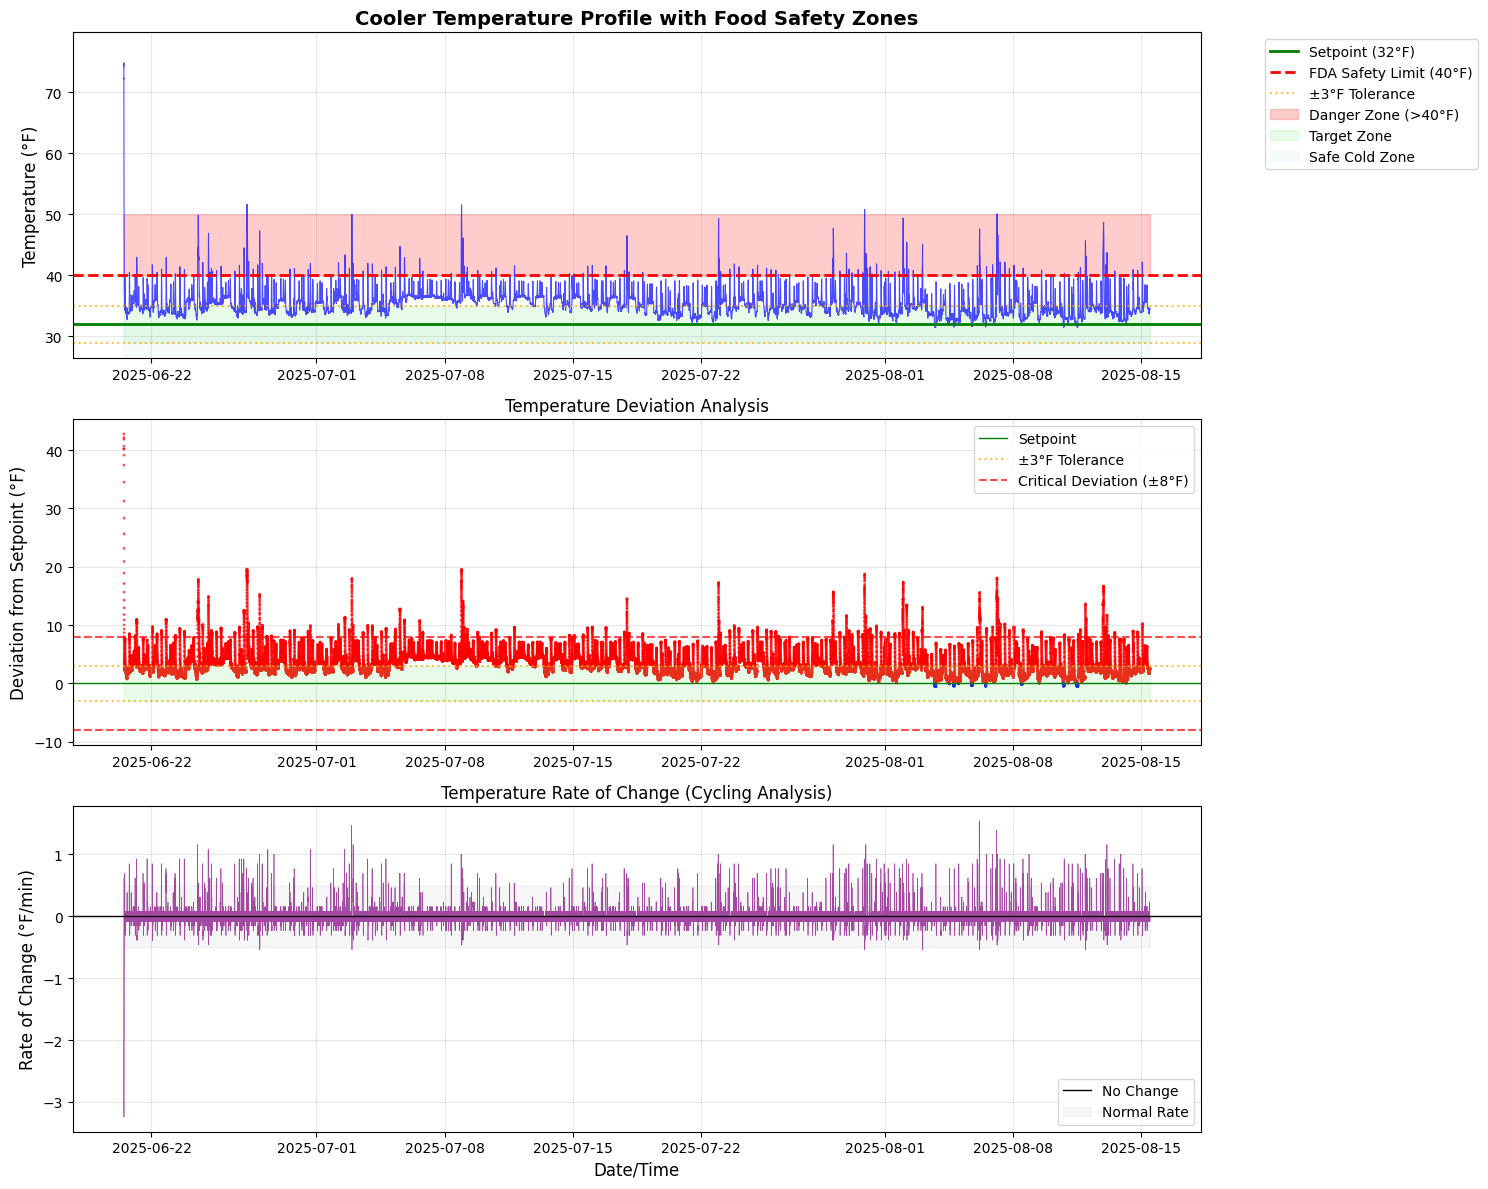

Creating temperature distribution and food safety analysis...


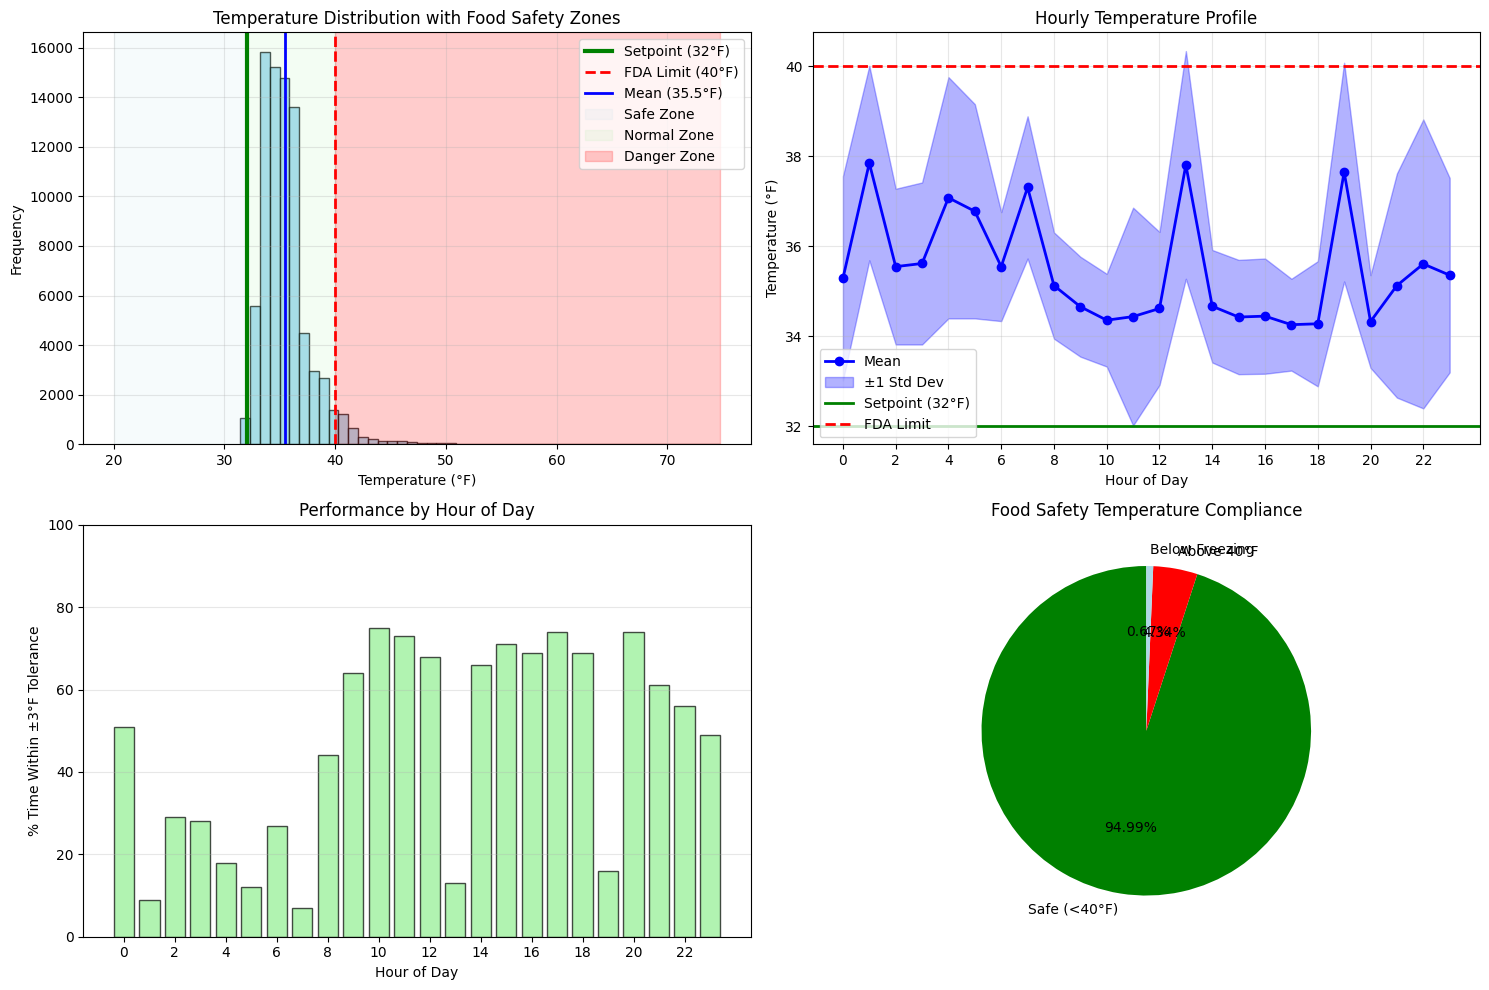

Creating compressor cycling analysis...


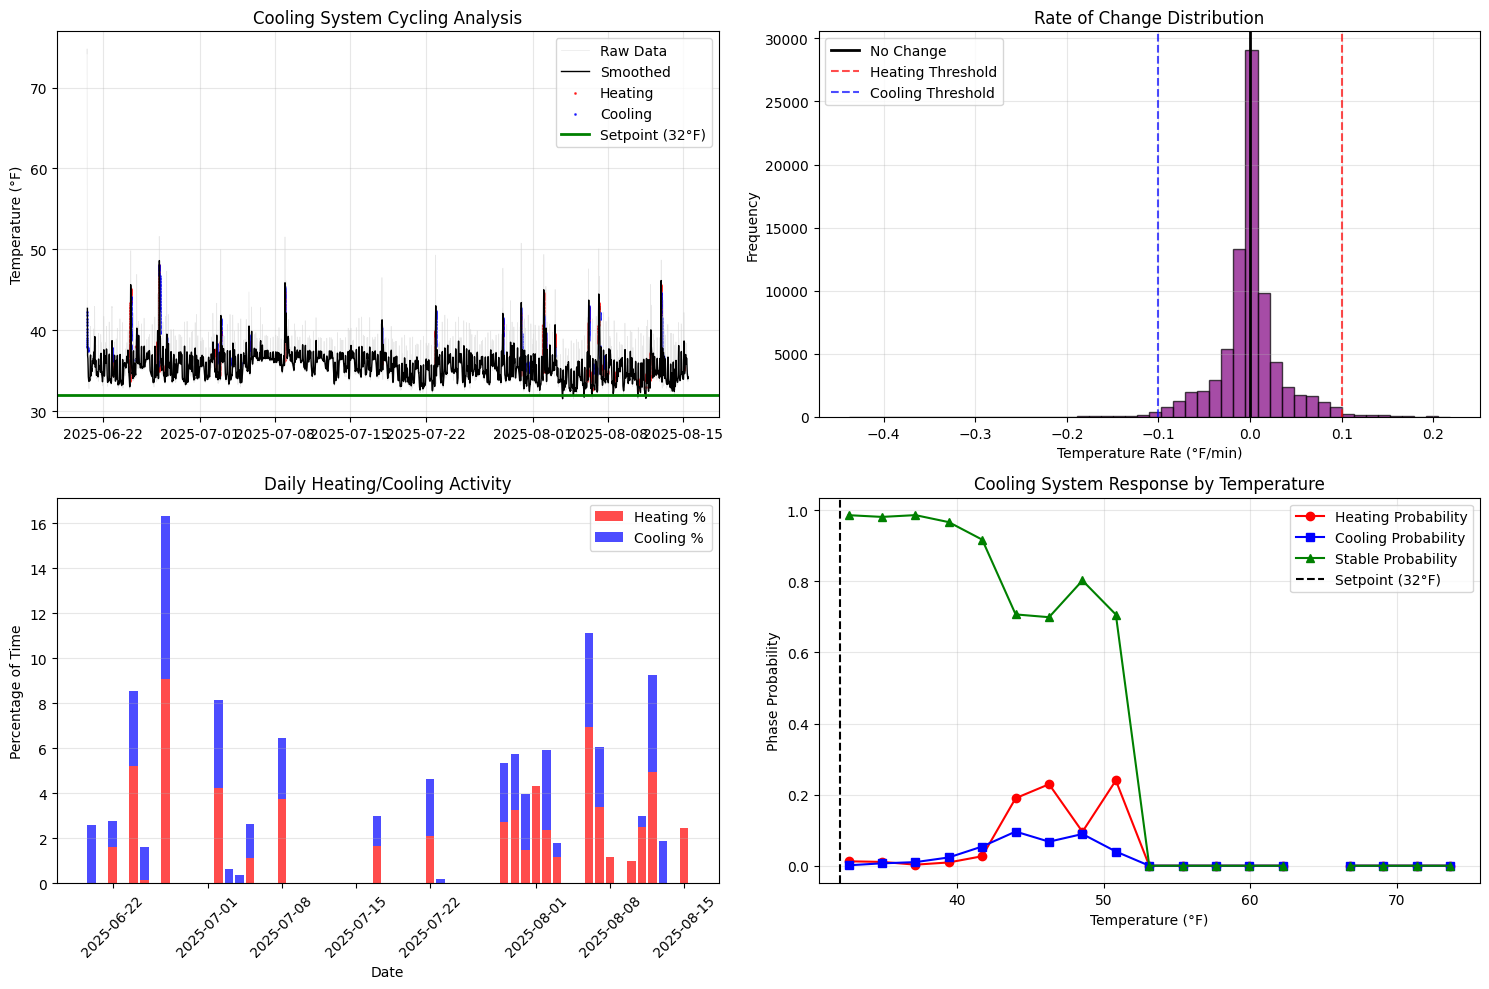

In [11]:
## 4. GENERATE ALL VISUALIZATIONS

print("\n" + "="*60)
print("GENERATING COOLER ANALYSIS VISUALIZATIONS")
print("="*60)

# Full cooler temperature profile
print("Creating cooler temperature profile with food safety zones...")
fig1 = plot_cooler_temperature_profile(df, setpoint=32)
plt.show()

# Distribution and food safety analysis
print("Creating temperature distribution and food safety analysis...")
fig2 = plot_cooler_distribution_analysis(df, setpoint=32)
plt.show()

# Cycling analysis
print("Creating compressor cycling analysis...")
fig3 = plot_cooler_cycling_analysis(df, setpoint=32)
plt.show()



DATE RANGE ANALYSIS EXAMPLES
Comparing first week vs last week of cooler operation...
First week: 2025-06-20 to 2025-06-27
Last week: 2025-08-08 to 2025-08-15
First week analysis...


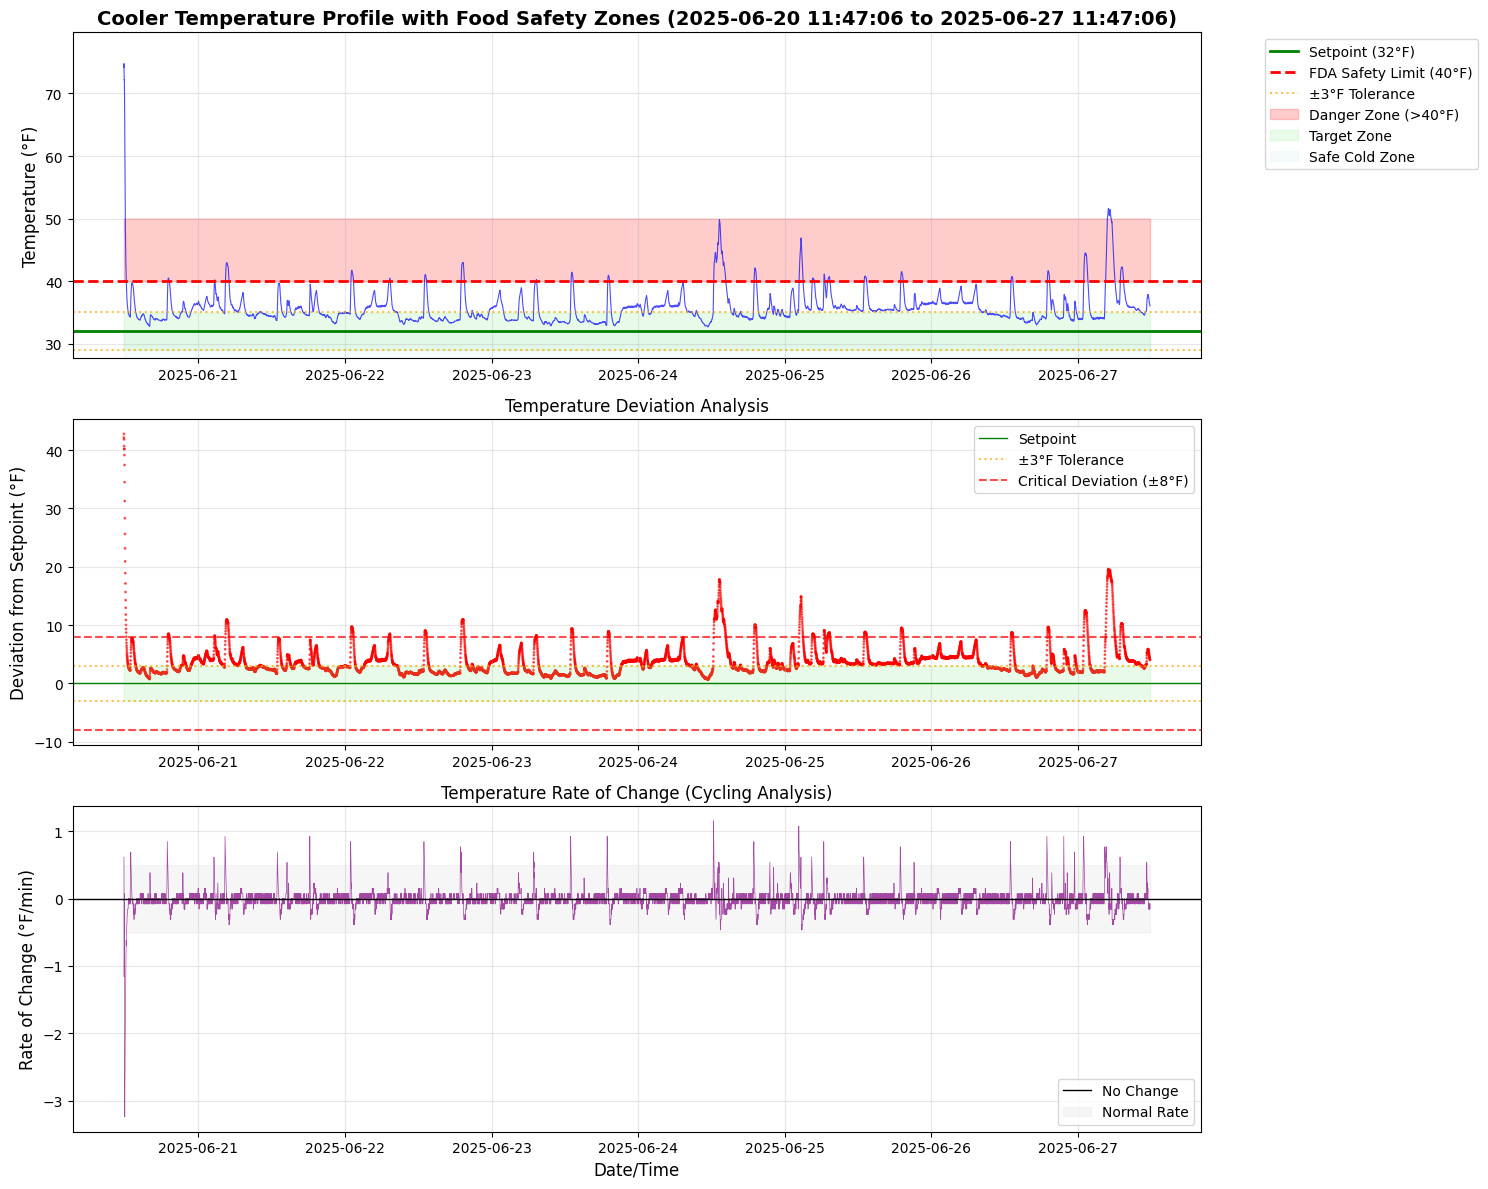

Last week analysis...


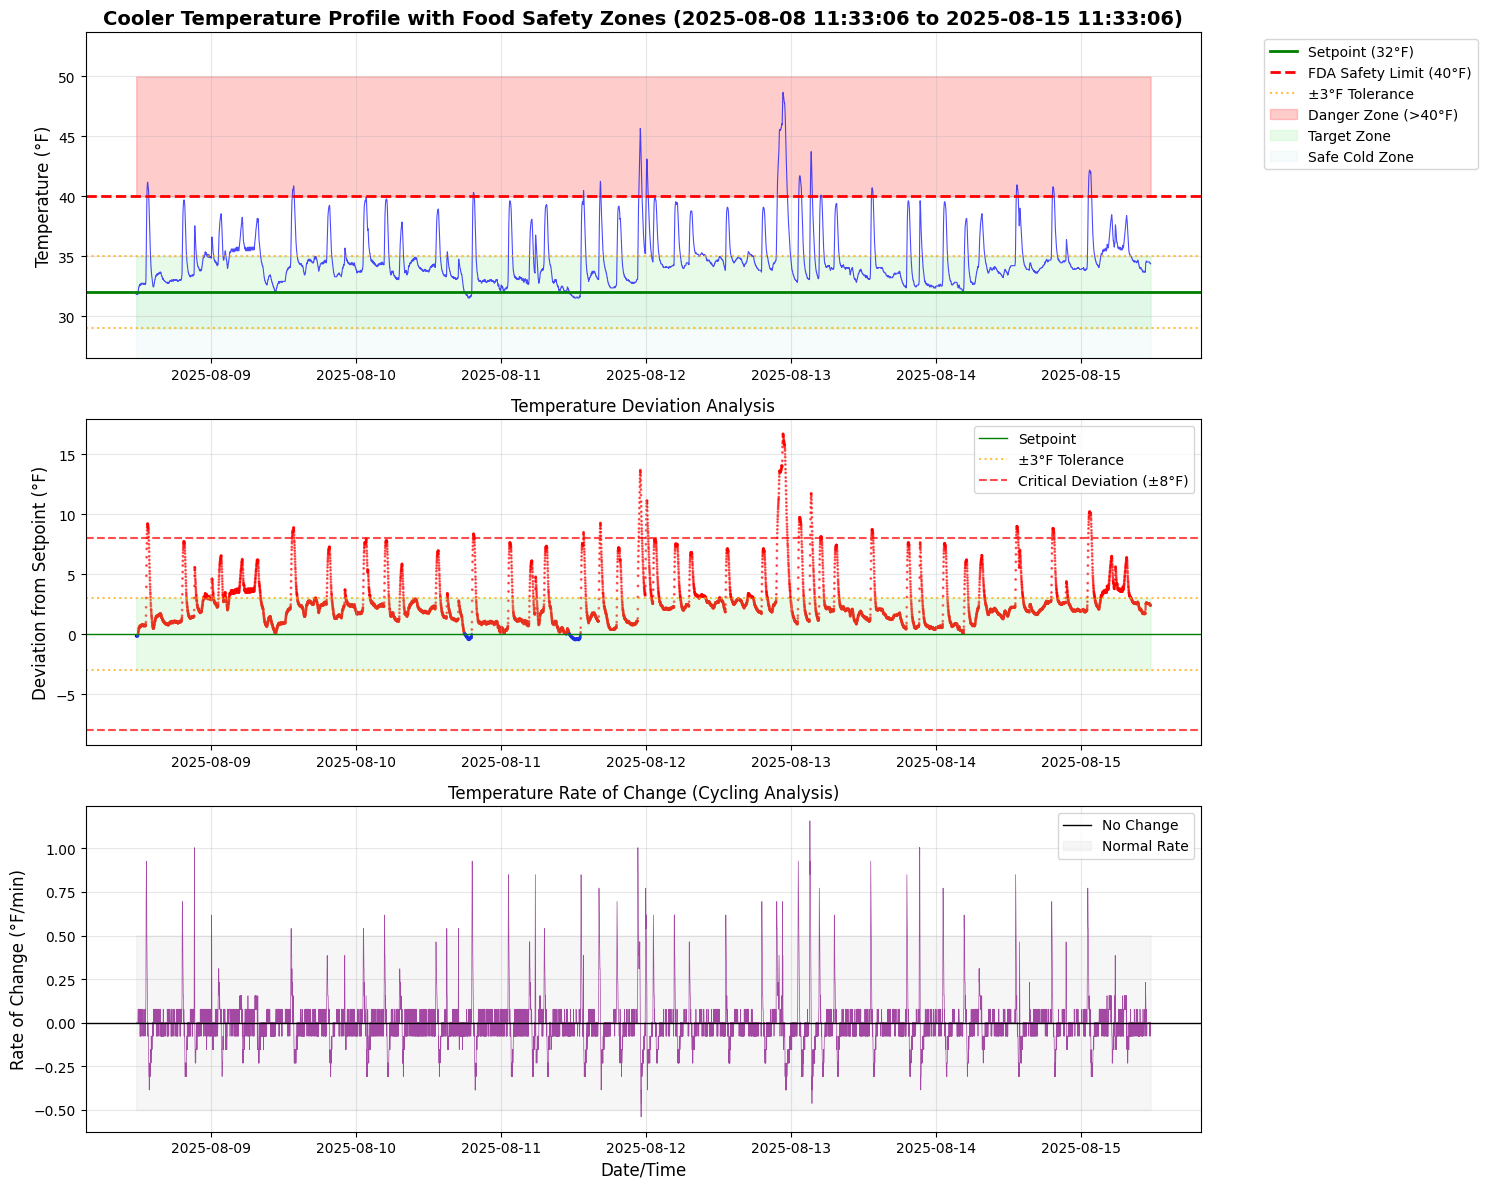

In [12]:
## 5. DATE RANGE ANALYSIS EXAMPLES

print("\n" + "="*60)
print("DATE RANGE ANALYSIS EXAMPLES")
print("="*60)

# Get first and last week of data for comparison
first_week_end = df['DateTime'].min() + timedelta(days=7)
last_week_start = df['DateTime'].max() - timedelta(days=7)

print("Comparing first week vs last week of cooler operation...")
print(f"First week: {df['DateTime'].min().strftime('%Y-%m-%d')} to {first_week_end.strftime('%Y-%m-%d')}")
print(f"Last week: {last_week_start.strftime('%Y-%m-%d')} to {df['DateTime'].max().strftime('%Y-%m-%d')}")

# Plot first week
print("First week analysis...")
fig4 = plot_cooler_temperature_profile(df, 
                                      start_date=df['DateTime'].min(), 
                                      end_date=first_week_end, 
                                      setpoint=32)
plt.show()

# Plot last week
print("Last week analysis...")
fig5 = plot_cooler_temperature_profile(df, 
                                      start_date=last_week_start, 
                                      end_date=df['DateTime'].max(), 
                                      setpoint=32)
plt.show()

In [13]:
## 6. COOLER-SPECIFIC ANALYSIS RECOMMENDATIONS

print("\n" + "="*70)
print("COOLER-SPECIFIC ANALYSIS RECOMMENDATIONS")
print("="*70)

print("1. FOOD SAFETY MONITORING:")
print("   - Continuous monitoring of 40°F FDA safety limit compliance")
print("   - HACCP (Hazard Analysis Critical Control Points) documentation")
print("   - Temperature excursion logs for food safety audits")

print("\n2. ENERGY EFFICIENCY OPTIMIZATION:")
print("   - Compressor cycling frequency analysis")
print("   - Identify optimal temperature bands to reduce cycling")
print("   - Door opening impact analysis (if door sensors available)")

print("\n3. MAINTENANCE SCHEDULING:")
print("   - Monitor cooling rate degradation over time")
print("   - Track temperature recovery time after loading")
print("   - Identify unusual cycling patterns indicating system issues")

print("\n4. SEASONAL ADJUSTMENTS:")
print("   - Compare performance across different ambient conditions")
print("   - Adjust setpoints seasonally for optimal efficiency")
print("   - Monitor heat load variations throughout the year")

print("\n5. PRODUCT QUALITY ASSURANCE:")
print("   - Track temperature uniformity across cooler zones")
print("   - Monitor temperature stability during different usage patterns")
print("   - Correlate temperature excursions with product quality issues")



COOLER-SPECIFIC ANALYSIS RECOMMENDATIONS
1. FOOD SAFETY MONITORING:
   - Continuous monitoring of 40°F FDA safety limit compliance
   - HACCP (Hazard Analysis Critical Control Points) documentation
   - Temperature excursion logs for food safety audits

2. ENERGY EFFICIENCY OPTIMIZATION:
   - Compressor cycling frequency analysis
   - Identify optimal temperature bands to reduce cycling
   - Door opening impact analysis (if door sensors available)

3. MAINTENANCE SCHEDULING:
   - Monitor cooling rate degradation over time
   - Track temperature recovery time after loading
   - Identify unusual cycling patterns indicating system issues

4. SEASONAL ADJUSTMENTS:
   - Compare performance across different ambient conditions
   - Adjust setpoints seasonally for optimal efficiency
   - Monitor heat load variations throughout the year

5. PRODUCT QUALITY ASSURANCE:
   - Track temperature uniformity across cooler zones
   - Monitor temperature stability during different usage patterns
   - Co

In [14]:
## 7. COOLER PERFORMANCE SUMMARY REPORT

print("\n" + "="*70)
print("COOLER PERFORMANCE EXECUTIVE SUMMARY")
print("="*70)

# Food safety performance grade
if metrics['percent_above_40f'] < 0.1 and metrics['percent_within_tolerance'] >= 95:
    safety_grade = "EXCELLENT"
    safety_color = "🟢"
elif metrics['percent_above_40f'] < 0.5 and metrics['percent_within_tolerance'] >= 90:
    safety_grade = "GOOD"
    safety_color = "🟡"
elif metrics['percent_above_40f'] < 1.0 and metrics['percent_within_tolerance'] >= 85:
    safety_grade = "ACCEPTABLE"
    safety_color = "🟠"
else:
    safety_grade = "NEEDS ATTENTION"
    safety_color = "🔴"

print(f"{safety_color} FOOD SAFETY PERFORMANCE: {safety_grade}")
print(f"   Time Above FDA Limit (40°F): {metrics['percent_above_40f']:.3f}%")
print(f"   Temperature Control Accuracy: {metrics['percent_within_tolerance']:.1f}%")

# System efficiency grade
cycles_per_hour = metrics['cycles_per_hour']
if cycles_per_hour < 6 and metrics['abs_mean_deviation_f'] < 2:
    efficiency_grade = "EFFICIENT"
    efficiency_color = "🟢"
elif cycles_per_hour < 12 and metrics['abs_mean_deviation_f'] < 3:
    efficiency_grade = "NORMAL"
    efficiency_color = "🟡"
else:
    efficiency_grade = "INEFFICIENT"
    efficiency_color = "🟠"

print(f"{efficiency_color} SYSTEM EFFICIENCY: {efficiency_grade}")
print(f"   Cycling Rate: {cycles_per_hour:.1f} cycles/hour")
print(f"   Mean Deviation: {metrics['abs_mean_deviation_f']:.2f}°F")

print(f"\n📊 KEY PERFORMANCE INDICATORS:")
print(f"   • Monitoring Period: {metrics['total_hours']/24:.1f} days")
print(f"   • Temperature Range: {metrics['min_temp_f']:.1f}°F to {metrics['max_temp_f']:.1f}°F")
print(f"   • Temperature Stability: ±{metrics['std_temp_f']:.2f}°F")
print(f"   • Critical Excursions: {metrics['num_excursions']:,} events")

print(f"\n🍎 FOOD SAFETY COMPLIANCE:")
print(f"   • Time Below FDA Limit (<40°F): {100-metrics['percent_above_40f']:.3f}%")
print(f"   • Time Below Freezing: {metrics['percent_below_freezing']:.2f}%")
print(f"   • Danger Zone Exposure: {metrics['time_in_danger_zone']:.3f}%")

print(f"\n⚡ SYSTEM EFFICIENCY METRICS:")
print(f"   • Compressor Cycles: {metrics['estimated_cycles']:,} total")
print(f"   • Max Cooling Rate: {abs(metrics['max_cooling_rate']):.2f}°F/min")
print(f"   • Max Heating Rate: {metrics['max_heating_rate']:.2f}°F/min")

print(f"\n⚠️  AREAS FOR ATTENTION:")
if metrics['percent_above_40f'] > 0.1:
    print(f"   • Food safety concern: {metrics['percent_above_40f']:.3f}% time above 40°F")
if metrics['cycles_per_hour'] > 10:
    print(f"   • High cycling rate: {metrics['cycles_per_hour']:.1f} cycles/hour (target <6)")
if metrics['abs_mean_deviation_f'] > 3:
    print(f"   • Poor temperature control: {metrics['abs_mean_deviation_f']:.2f}°F average deviation")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"   • Food Safety: Maintain <0.1% time above 40°F FDA limit")
print(f"   • Efficiency: Target <6 cycles/hour for optimal energy use")
print(f"   • Control: Keep temperature within ±3°F of setpoint >95% of time")
print(f"   • Monitoring: Set up real-time alerts for temperatures >38°F")

print(f"\n" + "="*70)
print("Cooler analysis completed successfully!")
print("="*70)


COOLER PERFORMANCE EXECUTIVE SUMMARY
🔴 FOOD SAFETY PERFORMANCE: NEEDS ATTENTION
   Time Above FDA Limit (40°F): 4.366%
   Temperature Control Accuracy: 46.7%
🟠 SYSTEM EFFICIENCY: INEFFICIENT
   Cycling Rate: 5.3 cycles/hour
   Mean Deviation: 3.51°F

📊 KEY PERFORMANCE INDICATORS:
   • Monitoring Period: 56.0 days
   • Temperature Range: 31.5°F to 74.8°F
   • Temperature Stability: ±2.25°F
   • Critical Excursions: 3,520 events

🍎 FOOD SAFETY COMPLIANCE:
   • Time Below FDA Limit (<40°F): 95.634%
   • Time Below Freezing: 0.68%
   • Danger Zone Exposure: 4.366%

⚡ SYSTEM EFFICIENCY METRICS:
   • Compressor Cycles: 7,057 total
   • Max Cooling Rate: 3.24°F/min
   • Max Heating Rate: 1.54°F/min

⚠️  AREAS FOR ATTENTION:
   • Food safety concern: 4.366% time above 40°F
   • Poor temperature control: 3.51°F average deviation

🎯 RECOMMENDATIONS:
   • Food Safety: Maintain <0.1% time above 40°F FDA limit
   • Efficiency: Target <6 cycles/hour for optimal energy use
   • Control: Keep tempera